In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

#Quality of image:
%config InlineBackend.figure_format = 'svg'
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import RobustScaler

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

pd.set_option('display.max_columns', 100)

# Import my own functions from utils file:
import import_ipynb
from utils_Rental_Cost import *

importing Jupyter notebook from utils_Rental_Cost.ipynb


In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Rental_Cost\\data')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Rental_Cost\\images\\Modeling')

In [3]:
df = pd.read_csv(dataDirectory + "\\rental_houses_Tohid_Final.csv")
print(df.shape)
df.head(2)

(10661, 16)


,city,area,rooms,bathroom,parking,floor,petFriendly,furnished,hoa,rent,tax,fireInsurance,allSpace,allCost,costPerArea,costPerRoom
0,São Paulo,70,2,1,1,7,Yes,Yes,2065,3300,211,42,4,2318,33.114286,579.500
1,São Paulo,320,4,4,0,20,Yes,No,1200,4960,1750,63,8,3013,9.415625,376.625


In [4]:
numFeatures = [x for x in df.columns if x not in ('rent', 'city', 'petFriendly', 'furnished')]
catFeatures = ['city', 'petFriendly', 'furnished']
targetFeature = ['rent']

**Encoding Categorical Features:**

In [5]:
df['furnished'] = df['furnished'].replace({'Yes': 1, 'No': 0})
df['petFriendly'] = df['petFriendly'].replace({'Yes': 1, 'No': 0})

In [6]:
print('Before dummification we have {} variables in train'.format(df.shape[1]))
df = pd.get_dummies(df, columns=['city'], drop_first=True)
print('After dummification we have {} variables in train'.format(df.shape[1]))

Before dummification we have 16 variables in train
After dummification we have 19 variables in train


In [7]:
# Making backup
df2 = df.copy(deep=True)

#df = df8.copy(deep=True)

In [8]:
df.head(2)

,area,rooms,bathroom,parking,floor,petFriendly,furnished,hoa,rent,tax,fireInsurance,allSpace,allCost,costPerArea,costPerRoom,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,70,2,1,1,7,1,1,2065,3300,211,42,4,2318,33.114286,579.500,0,0,0,1
1,320,4,4,0,20,1,0,1200,4960,1750,63,8,3013,9.415625,376.625,0,0,0,1


In [9]:
# We rename São Paulo because LGB model cannot read this column.
df.rename(columns={'city_São Paulo':'city_Sao Paulo'}, inplace=True)

**Applying scaler:**

In [10]:
scaler = RobustScaler()
df[numFeatures] = scaler.fit_transform(df[numFeatures])

**Spliting DataSet:**

In [11]:
X = df.drop('rent', axis=1)
y = df['rent'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
models = pd.DataFrame(index= ['R2', 'RMSE'], columns=['LR', 'RF', 'XGB', 'LGB'])
models

,LR,RF,XGB,LGB
R2,NaN,NaN,NaN,NaN
RMSE,NaN,NaN,NaN,NaN


In [13]:
def analyze_prediction(y_predicted, y_observed, result_matrix = None, model_name=None):
    
    rmse = np.sqrt(mean_squared_error(y_true=y_observed, y_pred=y_predicted))
    r2 = r2_score(y_true=y_observed, y_pred=y_predicted)
    
    if (model_name != None):
        result_matrix.loc['R2', model_name] = r2
        result_matrix.loc['RMSE', model_name] = rmse
        

    print("R2, RMSE")
    return r2, rmse

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='LR')

R2, RMSE


(0.9890967172989769, 365.43844542143916)

In [15]:
np.random.seed(123)

In [16]:
model = RandomForestRegressor(random_state= 123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='RF')

R2, RMSE


(0.9905056685997179, 341.0105316353318)

In [17]:
model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')

R2, RMSE


(0.9920754380190512, 311.5467547005355)

In [18]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [19]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='LGB')

R2, RMSE


(0.9907373308777653, 336.82449996877517)

In [20]:
models

,LR,RF,XGB,LGB
R2,0.989097,0.990506,0.992075,0.990737
RMSE,365.438,341.011,311.547,336.824


**Insights:**
- As it was guessed, different models could learn without complexity from input data.
- Without tuning, we could reach RMSE as 286 with default Random Forest.
- Of course, we can continue with hyperparameter tuning.

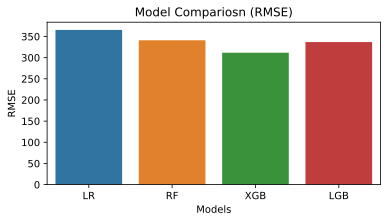

In [21]:
fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(models.iloc[1].index, models.iloc[1].values, ax=ax)
ax.set_title('Model Compariosn (RMSE)')
ax.set_xlabel('Models')
ax.set_ylabel('RMSE');
plt.savefig(imageDirectory + '\\model_1.png', dpi=140,  bbox_inches='tight')

**Random Forest Parameter Tuning:**

In [22]:
# Based on my experiance, I do not need to tune n_estimators. A quite high value such as 1000 is recommended. 
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

In [23]:
# Number of trees in random forest
learning_rateLst=[0.01, 0.3, 0.9]
max_depthLst = [3, 4, 10]
n_estimatorsLst = [200, 300, 400]


space = {'n_estimators': hp.choice('n_estimators', n_estimatorsLst),
         'max_depth': hp.choice('max_depth', max_depthLst),
         'learning_rate': hp.choice('learning_rate', learning_rateLst),
         'random_state':hp.choice('random_state', [0])
        }

best = 0
def get_acc_status(clf,X_,y):
    avg_score = cross_val_score(clf, X_, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    loss = -avg_score
    return {'loss': loss, 'status': STATUS_OK}

def obj_fnc(params): 
    global best

    clf = XGBRegressor(**params)
    res = get_acc_status(clf,X_train,y_train)
    loss = res['loss']    
    
    if loss < best:
        best = loss
    #print ('new best:', -best, params)
    return (res)


# Trials object to track progress
bayes_trials = Trials()

# Optimize
best_params = fmin(obj_fnc, space, algo=tpe.suggest, max_evals=20, trials= bayes_trials)

100%|█████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.80s/trial, best loss: 301.8795381712711]


In [24]:
best_params

{'learning_rate': 1, 'max_depth': 0, 'n_estimators': 0, 'random_state': 0}

In [25]:
# Note: Output of the above cell is based on index which starts from 0.
# For example, for the learning rate we passed: [0.1, 0.3, 0.5, 0.9]
# and in the output, it shows 2. By starting from 0, the index 2 indicates 0.1 as the learning rate. 

model = XGBRegressor(n_estimators = 200,
                     max_depth = 3,
                     learning_rate=0.3,
                     random_state= 0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')

R2, RMSE


(0.99333686934182, 285.67666231394816)

In [26]:
model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

r2Base, rmseBase = analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')
print(r2Base, rmseBase )

R2, RMSE
0.9920754380190512 311.5467547005355


In [27]:
model = XGBRegressor(n_estimators = 200,
                     max_depth = 3,
                     learning_rate=0.3,
                     random_state= 0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

r2New, rmseNew = analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')
print(r2New, rmseNew)

R2, RMSE
0.99333686934182 285.67666231394816


The improvement in RMSE: 9.06%


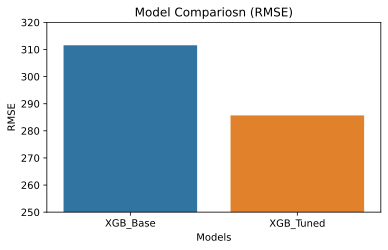

In [28]:
improvement = round(100*(rmseBase-rmseNew)/rmseNew,2)
print("The improvement in RMSE: {}%".format(improvement))

lst1 = ['XGB_Base', 'XGB_Tuned']
lst2 = [rmseBase, rmseNew]

fig, ax = plt.subplots(figsize=(6,3.5))
sns.barplot(lst1, lst2, ax=ax)
ax.set_title('Model Compariosn (RMSE)')
ax.set_xlabel('Models')
ax.set_ylabel('RMSE');
ax.set(ylim=(250, 320))
plt.savefig(imageDirectory + '\\model_Comparison.png', dpi=140,  bbox_inches='tight')